In [ ]:
!pip install darts

     |████████████████████████████████| 326 kB 4.9 MB/s 
     |████████████████████████████████| 165 kB 63.6 MB/s 
     |████████████████████████████████| 9.8 MB 54.5 MB/s 
     |████████████████████████████████| 11.2 MB 42.6 MB/s 
     |████████████████████████████████| 792 kB 54.3 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 1.4 MB 35.1 MB/s 
     |████████████████████████████████| 375 kB 56.0 MB/s 
     |████████████████████████████████| 895 kB 44.0 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639777 sha256=7f5c0f28097115cc8ef31ba7d394e40d1cd02e4c43d8fbc58bf5e999b1e19793
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels

In [ ]:
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('AirQuality.csv',sep=";",parse_dates=[['Date', 'Time']],decimal=',',na_values=-200,na_filter=True)
data.drop(["Unnamed: 15","Unnamed: 16"],axis = 1,inplace = True)

data.fillna(method='ffill',inplace=True)
data.drop_duplicates(inplace=True)

data.drop(9357,inplace = True)
data['Date_Time'] = pd.to_datetime(data['Date_Time'],format="%d/%m/%Y %H.%M.%S")

In [ ]:
d_r = data.set_index('Date_Time')

In [ ]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [ ]:
d_r.set_index(add_freq(d_r.index),inplace= True)

In [ ]:
train_data = d_r[['CO(GT)','T']].iloc[6:6+168]
test_data = d_r[['CO(GT)','T']].iloc[6+168:6+2*168]

In [ ]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

In [ ]:
model_nbeats = NBEATSModel(
    input_chunk_length=72,
    output_chunk_length=24,
    generic_architecture=True,
    num_blocks=3,
    num_layers=4,
    layer_widths=256,
    n_epochs=15,
    nr_epochs_val_period=1,
    batch_size=1,
    model_name="nbeats_interpretable_run",
)

In [ ]:
series=TimeSeries.from_dataframe(data.iloc[6:6+168],time_col='Date_Time',value_cols='CO(GT)')

In [ ]:
model_nbeats.fit(series=series,verbose=True)

In [ ]:
nbeats_preds = model_nbeats.predict(168,verbose=True)

100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


In [ ]:
val_series=TimeSeries.from_dataframe(data.iloc[6+168:6+2*168],time_col='Date_Time',value_cols='CO(GT)')

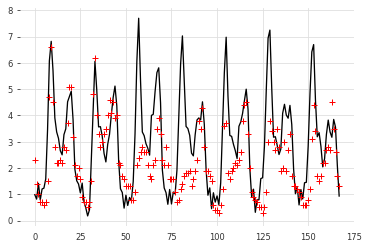

In [ ]:
plt.plot(nbeats_preds.values().squeeze())
plt.plot(d_r['CO(GT)'].iloc[6+168:6+2*168].values,'r+')

In [ ]:
preds = []
mape = []
for i in range(7,14):
  series=TimeSeries.from_dataframe(data.iloc[6:6+i*24],time_col='Date_Time',value_cols='CO(GT)')
  model_nbeats.fit(series=series)
  nbeats_preds = model_nbeats.predict(24,verbose=True)
  print(f"NBEATS MAPE : {mean_absolute_percentage_error(nbeats_preds.values().squeeze(),d_r['CO(GT)'].iloc[6+i*24:6+i*24+24])}")
  preds.append([nbeats_preds.values().squeeze()])
  mape.append(mean_absolute_percentage_error(nbeats_preds.values().squeeze(),d_r['CO(GT)'].iloc[6+i*24:6+i*24+24]))

print(sum(mape)/len(mape))


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
print(f"NBEATS MAPE : {mean_absolute_percentage_error(nbeats_preds.values().squeeze()[:24],d_r['CO(GT)'].iloc[6+168:6+168+24])}")

NBEATS MAPE : 0.3000389947717336


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


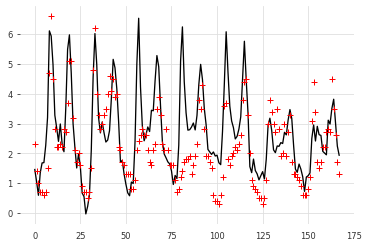

In [ ]:
t = list(preds[0])
for i in range(1,len(preds)):
    t = t+list(preds[i])
assert len(t)==168, f"len is : {len(t)}"
plt.plot(t)
plt.plot(d_r['CO(GT)'].iloc[6+168:6+2*168].values,'r+')
plt.legend()

In [ ]:
preds = np.array(preds).squeeze()

In [ ]:
len(preds)

7

In [ ]:
!pip list

NBEATS with T starts here

In [ ]:
model_nbeats_t = NBEATSModel(
    input_chunk_length=72,
    output_chunk_length=24,
    generic_architecture=True,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=15,
    nr_epochs_val_period=1,
    batch_size=1,
    model_name="nbeats_interpretable_run",
)

In [ ]:
series=TimeSeries.from_dataframe(data.iloc[6:6+168],time_col='Date_Time',value_cols='T')

In [ ]:
model_nbeats_t.fit(series=series,verbose=True)

[2022-02-01 12:41:42,000] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-01 12:41:42,000] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 73 samples.
[2022-02-01 12:41:43,638] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-01 12:41:43,638] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  7%|▋         | 1/15 [02:25<34:01, 145.84s/it]

In [ ]:
nbeats_preds = model_nbeats_t.predict(168,verbose=True)

In [ ]:
plt.plot(nbeats_preds.values().squeeze())
plt.plot(d_r['T'].iloc[6+168:6+2*168].values,'r+')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
print(f"NBEATS MAPE : {mean_absolute_percentage_error(nbeats_preds.values().squeeze()[:24],d_r['CO(GT)'].iloc[6+168:6+168+24])}")

In [ ]:
preds = []
mape = []
for i in range(7,14):
  series=TimeSeries.from_dataframe(data.iloc[6:6+i*24],time_col='Date_Time',value_cols='CO(GT)')
  model_nbeats_t.fit(series=series)
  nbeats_preds = model_nbeats_t.predict(24,verbose=True)
  print(f"NBEATS MAPE : {mean_absolute_percentage_error(nbeats_preds.values().squeeze(),d_r['CO(GT)'].iloc[6+i*24:6+i*24+24])}")
  preds.append([nbeats_preds.values().squeeze()])
  mape.append(mean_absolute_percentage_error(nbeats_preds.values().squeeze(),d_r['CO(GT)'].iloc[6+i*24:6+i*24+24]))

print(sum(mape)/len(mape))

In [ ]:
t = list(preds[0])
for i in range(1,len(preds)):
    t = t+list(preds[i])
assert len(t)==168, f"len is : {len(t)}"
plt.plot(t)
plt.plot(d_r['CO(GT)'].iloc[6+168:6+2*168].values,'r+')
